# import

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import autoaugment, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from tqdm import tqdm
import models.optimizer.optimizer as optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from helper.training_early_stop import EarlyStop
import helper.utility as utility
from models.new_models import DCNN_v0 as m

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             320
              ReLU-2           [-1, 32, 62, 62]               0
            Conv2d-3           [-1, 64, 60, 60]          18,496
              ReLU-4           [-1, 64, 60, 60]               0
         MaxPool2d-5           [-1, 64, 30, 30]               0
           Dropout-6           [-1, 64, 30, 30]               0
            Conv2d-7           [-1, 64, 28, 28]          36,928
              ReLU-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 64, 26, 26]          36,928
             ReLU-10           [-1, 64, 26, 26]               0
           Conv2d-11          [-1, 128, 24, 24]          73,856
             ReLU-12          [-1, 128, 24, 24]               0
        MaxPool2d-13          [-1, 128, 12, 12]               0
           Conv2d-14          [-1, 128,

# select device

In [5]:
device = utility.select_devices(use_cudnn_if_avaliable=True)

using CUDA + cudnn


# Data Pre-processing

In [6]:
utility.split_dataset_by_ratio(source_path='../dataset/test/', target_path='../dataset/split', ratio=0.8)

### transformer parameter

In [3]:
# Alex 227, VGG 224, ResNet 224, Unet 96
size = (64, 64)
batch_size = 32
channels = 1

data_transforms_R = utility.grayscale_transform_rotation(channels, size, 25,)
data_transforms_vf = utility.grayscale_transform_verticalflip(channels, size, 0.8)
data_transforms_hf = utility.grayscale_transform_horizontalflip(channels, size, 0.8)
data_transforms_crop = utility.grayscale_transform_crop(channels, size, scale=(0.2, 1))
data_transforms_translate = utility.grayscale_transform_trainslate(channels, size, value=(0.2, 0))
data_transforms_shear = utility.grayscale_transform_shear(channels, size, value=(-10, 10))

data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=channels), 
    transforms.Resize(size),
    transforms.ToTensor()
])

transforms_AutoAug = transforms.Compose([
    transforms.Grayscale(num_output_channels=channels), 
    transforms.RandomResizedCrop(size),
    transforms.RandomHorizontalFlip(0.5),
    autoaugment.AutoAugment(),
    transforms.ToTensor()
])


### data duplicated (use if needed)

In [4]:
class_list = ['disgust', 'fear']
utility.create_augmentation_dataset('../RAF-DB/splited_data/train_data/', 'RAFDB12', class_list)

data augmentation is already created at [../augmentation_dataset/RAFDB12/]


### add noise

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import os
import cv2
import random

def add_gaussian_noise(image, mean=0, sigma=25):
    row, col, ch = image.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = np.clip(image + gauss, 0, 255)
    return noisy.astype(np.uint8)

# Function to add salt-and-pepper noise to an image
def add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    row, col, ch = image.shape
    noisy = np.copy(image)

    # Add salt noise
    salt_pixels = np.random.rand(row, col, ch) < salt_prob
    noisy[salt_pixels] = 255

    # Add pepper noise
    pepper_pixels = np.random.rand(row, col, ch) < pepper_prob
    noisy[pepper_pixels] = 0

    return noisy.astype(np.uint8)

# Specify the path to your image dataset
input_folder = "../RAF-DB/splited_data/train_data/"
output_folder = "../RAF-DB/splited_data/noisy_pepper_train_data"

total = 0
generate = 0
# {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'netural': 4, 'sad': 5, 'surprise': 6}

noisy_classes = ['angry', 'happy', 'netural', 'sad', 'suprise'] 
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    # Iterate through the images in the input folder
    for classfoldername in os.listdir(input_folder):
        class_path = os.path.join(input_folder, classfoldername)
        for filename in os.listdir(class_path):
            total += 1
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(class_path, filename)
                original_image = cv2.imread(image_path)
                # Add noise to the image
                select = random.random()
                noisy_image = add_gaussian_noise(original_image)
                if select > 0.5:
                    noisy_image = add_salt_and_pepper_noise(original_image)
                # Save the noisy image to the output folder
                output_class_path = os.path.join(output_folder, classfoldername)
                if not os.path.exists(output_class_path):
                    os.mkdir(output_class_path)
                r = random.random()
                if r > 0.6 and (classfoldername in noisy_classes):
                    generate += 1
                    output_path = os.path.join(output_class_path,f"noisy_{filename}")
                    cv2.imwrite(output_path, noisy_image)
                else:
                    output_path = os.path.join(output_class_path,f"{filename}")
                    cv2.imwrite(output_path, original_image)
    print(f'Total: {total}, generate: {generate}')
else:
    print(f'folder [{output_folder}] is already existed')

folder [../RAF-DB/splited_data/noisy_pepper_train_data] is already existed


### create dataloader

#### dataloader 1 RAF-DB

In [6]:
train_path = '../RAF-DB/splited_data/train_data'
train_path2 = '../dataset/splited_data/train_data/'
train_path3 = '../dataset2_MMAFEDB/train/'
aug_train_path = '../augmentation_dataset/RAFDB12/'
aug_train_path2 = '../augmentation_dataset/FER2013/'
val_path = '../RAF-DB/splited_data/validation_data/'
test_path = '../RAF-DB/test'
rotation = datasets.ImageFolder(aug_train_path, transform=data_transforms_R)
vertical_flip = datasets.ImageFolder(aug_train_path, transform=data_transforms_vf)
horizontal_flip = datasets.ImageFolder(aug_train_path, transform=data_transforms_hf)
crop = datasets.ImageFolder(aug_train_path, transform=data_transforms_crop)
shear = datasets.ImageFolder(aug_train_path, transform=data_transforms_shear)
translate = datasets.ImageFolder(aug_train_path, transform=data_transforms_translate)

train_dataset1 = datasets.ImageFolder(train_path, transform=data_transforms)
train_dataset2 = datasets.ImageFolder(train_path2, transform=data_transforms)
# train_dataset3 = datasets.ImageFolder(train_path3, transform=data_transforms)
# train_dataset1 = ConcatDataset([train_dataset1, train_dataset2, train_dataset3])
# train_dataset1 = ConcatDataset([train_dataset1, crop, shear, translate, rotation, horizontal_flip])

dataset_list = [train_dataset1, train_dataset2]
for _ in range(2):
    dataset_list.append(datasets.ImageFolder(aug_train_path, transform=transforms_AutoAug))
    dataset_list.append(datasets.ImageFolder(aug_train_path2, transform=transforms_AutoAug))
train_dataset1 = ConcatDataset(dataset_list)


val_dataset1 = datasets.ImageFolder(val_path, transform=data_transforms)
test_dataset1 = datasets.ImageFolder(test_path, transform=data_transforms)

train_loader = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=16)
val_loader = DataLoader(val_dataset1, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)
test_loader = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=16)

#### select data loader

In [7]:
tl = train_loader
vl = val_loader
test_l1 = test_loader
test_l2 = test_loader
test_l3 = test_loader

### check data detial

In [8]:
# check if the size of each label is balanced
print('Train label:')
train_label_count = utility.check_label_size(tl)
print('val label:')
val_label_count = utility.check_label_size(vl)

Train label:
Label 0: 3764 samples
Label 1: 2763 samples
Label 2: 10503 samples
Label 3: 9593 samples
Label 4: 5995 samples
Label 5: 5453 samples
Label 6: 3572 samples
val label:
Label 0: 141 samples
Label 1: 144 samples
Label 2: 57 samples
Label 3: 955 samples
Label 4: 505 samples
Label 5: 397 samples
Label 6: 258 samples


# Model parameter

In [9]:
# todo: select optimizer
optimizer_name = "Adam"  # or "SGD"
# optimizer_name = "SGD"
dataset = '_[RAF(AutoAug12x2),FER(AutoAug12x2)]'
lr = '_LR'
wb = 'WB(M)'
L2 = 0.01
smooth = 0
additional =''
additional = f'_[L2:{L2}]_2nd'
# additional = f'_[L2:{L2},smooth:{smooth}]'
# saving path
m.update_file_name(optimizer_name + dataset + lr + wb + additional)

# initialize model
if not os.path.exists(m.record_save_path):
    os.makedirs(m.record_save_path)

model = m.EmotionCNN(num_classes=7, input_channel=channels)

In [10]:
# adjust the weight of each label
list1 = train_label_count.values()
list2 = [0.71, 0.41, 0.55, 0.93, 0.84, 0.82, 0.79]
list3 = [1.5, 2.25, 2.25, 0.3, 0.8, 0.8, 0.7]
print(f'Distribution: {list1}\nvanilla accuracy: {list2}')
# Calculate weights as the inverse of list
def adjust_weights(list1, list2, list3, wb):
    if wb == '':
        return None
    if '(D)' in wb:
        print('use distribution weight')
        list = list1
    elif '(M)' in wb:
        print('use manual assign weight')
        print(list3)
        return torch.tensor(list3)
    else:
        print('use vanilla accuracy weight')
        list = list2
    weights = [1.0 / e for e in list]
    weights_sum = sum(weights)
    weights = [w / weights_sum for w in weights]
    weights_tensor = torch.tensor(weights)
    print(list)
    print(weights_tensor)
    return weights_tensor
weights_tensor = adjust_weights(list1, list2, list3, wb)
criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=weights_tensor).to(device) 

Distribution: dict_values([3764, 2763, 10503, 9593, 5995, 5453, 3572])
vanilla accuracy: [0.71, 0.41, 0.55, 0.93, 0.84, 0.82, 0.79]
use manual assign weight
[1.5, 2.25, 2.25, 0.3, 0.8, 0.8, 0.7]


In [11]:
# loss-function and optimizer
optimizer_ = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=L2) # defalut lr-0.0001, L2: 0.001
# optimizer_ = optimizer.create_optimizer(model.parameters(), optimizer_name)

lr_scheduler = ReduceLROnPlateau(
            optimizer_,
            mode='max',                 # 'max' for monitoring validation accuracy
            factor=0.4,                 # factor by which the learning rate will be reduced
            patience=2,                 # number of epochs with no improvement to trigger LR reduction
            min_lr=1e-7,                # minimum learning rate
            verbose=1                   # (1: print messages, 0: not print message)
        )

#### earlystoping parameters

In [12]:
# average loss / epoch
loss_history_per_epoch = []
# correct prediction / epoch
correct_prediction_pre_epoch = []
# accuracy / epoch
accuracy_per_epoch = []
# validation loss
val_loss_per_epoch = []
# validation accuracy
val_accuracy_per_epoch = []

In [13]:
# training model
num_epochs = 150

# early stopping variables
stop_counter = 10 # number of count to trigger early stop
stop_counter_window = 15 # a range to check stop_counter
loss_different = 0.001 # different between the best val loss and the most recent one
accuracy_different = 0.0025
stop_counter_interval = 30 # check for early stop for every stop_counter_interval
counter = 0 # number of count for every trail of early stop
is_always = True # always check for early stop, set to true will ignore other setting except stop_counter
is_exe = False # is early stop running
run_after =0
early_stopping = EarlyStop(m.pth_save_path, m.pth_save_path_loss, stop_counter, 
                           accuracy_different, loss_different, type="accuracy")

# 2. Model training

In [14]:
model.to(device)
stop = True
# progress bar
process = tqdm(range(num_epochs), bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}', colour='green', unit='epoch')

for epoch in process:
    running_loss = 0.0
    accuracy = 0.0
    model.train()
    for inputs, labels in tl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        optimizer_.zero_grad()
        probability = nn.functional.softmax(outputs, dim=1)
        prediction = torch.argmax(probability, dim=1)
        num_correct_prediction = (prediction == labels).sum().item()
        correct_prediction_pre_epoch.append(num_correct_prediction)
        accuracy += num_correct_prediction / inputs.shape[0]
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer_.step()
    # save training status
    loss_history_per_epoch.append((running_loss / len(tl)))
    accuracy_per_epoch.append((accuracy / len(tl)))

    # training validation + early stopping
    if epoch >= run_after and (is_always or is_exe or epoch % stop_counter_interval == 0):
        val_loss = 0.0
        val_accuracy = 0.0

        if not is_always and epoch% stop_counter_interval ==0:
            early_stopping.counter = 0
            is_exe = True

        counter += 1

        if not is_always and counter >= stop_counter_window:
            counter = 0
            is_exe = False
        model.eval()
        with torch.no_grad():
            for inputs, labels in vl:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                probability = nn.functional.softmax(outputs, dim=1)
                prediction = torch.argmax(probability, dim=1)
                num_correct_prediction = (prediction == labels).sum().item()
                accuracy = num_correct_prediction / inputs.shape[0]
                val_accuracy += accuracy
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss = val_loss / len(vl)
        val_accuracy = val_accuracy / len(vl)
        val_loss_per_epoch.append(val_loss)
        val_accuracy_per_epoch.append(val_accuracy)

        early_stopping.check_status(model, val_accuracy, val_loss)

        # display recently 5 average loss of epochs
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"val loss= {'{:.5f}'.format(val_loss_per_epoch[-1])} - "
                                f"best_loss= {'{:.5f}'.format(early_stopping.best_of_all_value_loss)} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])} - "
                                f"val accuracy= {'{:.3%}'.format(val_accuracy_per_epoch[-1])} - "
                                f"best= {'{:.3%}'.format(early_stopping.best_of_all_value)} - "
                                f"Counter= {early_stopping.counter}/{stop_counter}")
        if lr != '':
            lr_scheduler.step(val_accuracy)
    else:
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])}")

    if stop and early_stopping.early_stop:
        print('\nTrigger Early Stopping\n')
        early_stopping.early_stop = False
        break

  0%|                    | 0/150 [00:00<?, ?epoch/s]

loss= 1.07174 - val loss= 1.12305 - best_loss= 1.10964 - accuracy= 53.633% - val accuracy= 59.963% - best= 61.494% - Counter= 3/10:   7%|█▎                  | 10/150 [10:15<2:22:31, 61.08s/epoch]

Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.


loss= 0.90898 - val loss= 1.00560 - best_loss= 0.94319 - accuracy= 61.884% - val accuracy= 63.795% - best= 66.670% - Counter= 3/10:  10%|██                  | 15/150 [15:20<2:17:15, 61.00s/epoch]

Epoch 00015: reducing learning rate of group 0 to 1.6000e-05.


loss= 0.76644 - val loss= 0.81733 - best_loss= 0.79067 - accuracy= 68.553% - val accuracy= 71.042% - best= 72.445% - Counter= 3/10:  14%|██▊                 | 21/150 [21:26<2:10:54, 60.89s/epoch]

Epoch 00021: reducing learning rate of group 0 to 6.4000e-06.


loss= 0.64996 - val loss= 0.75274 - best_loss= 0.70652 - accuracy= 73.338% - val accuracy= 74.497% - best= 75.987% - Counter= 3/10:  19%|███▋                | 28/150 [28:32<2:03:16, 60.63s/epoch]

Epoch 00028: reducing learning rate of group 0 to 2.5600e-06.


loss= 0.60848 - val loss= 0.72033 - best_loss= 0.69587 - accuracy= 75.274% - val accuracy= 75.459% - best= 76.578% - Counter= 3/10:  22%|████▍               | 33/150 [33:33<1:58:03, 60.54s/epoch]

Epoch 00033: reducing learning rate of group 0 to 1.0240e-06.


loss= 0.58118 - val loss= 0.71057 - best_loss= 0.67117 - accuracy= 76.623% - val accuracy= 76.404% - best= 77.297% - Counter= 4/10:  27%|█████▎              | 40/150 [40:38<1:51:15, 60.69s/epoch]

Epoch 00040: reducing learning rate of group 0 to 4.0960e-07.


loss= 0.57041 - val loss= 0.66409 - best_loss= 0.66409 - accuracy= 77.132% - val accuracy= 77.674% - best= 77.744% - Counter= 3/10:  29%|█████▊              | 44/150 [44:42<1:47:21, 60.77s/epoch]

Epoch 00044: reducing learning rate of group 0 to 1.6384e-07.


loss= 0.56621 - val loss= 0.69382 - best_loss= 0.66409 - accuracy= 76.943% - val accuracy= 77.013% - best= 77.744% - Counter= 6/10:  31%|██████▎             | 47/150 [47:45<1:44:58, 61.16s/epoch]

Epoch 00047: reducing learning rate of group 0 to 1.0000e-07.


loss= 0.56843 - val loss= 0.69942 - best_loss= 0.66409 - accuracy= 76.973% - val accuracy= 76.688% - best= 77.744% - Counter= 0/10:  33%|██████▋             | 50/150 [51:49<1:43:38, 62.19s/epoch]


Trigger Early Stopping



# 3. Save model and records

In [15]:
# save the pth file
torch.save(model.state_dict(), m.pth_manual_save_path)

utility.save_pickle_files(loss_history_per_epoch, m.record_save_path + '/loss_history.pkl')
utility.save_pickle_files(accuracy_per_epoch, m.record_save_path + '/accuracy_history.pkl')
utility.save_pickle_files(val_loss_per_epoch, m.record_save_path + '/val_loss_history.pkl')
utility.save_pickle_files(val_accuracy_per_epoch, m.record_save_path + '/val_accuracy_history.pkl')

# 4. Plot records and Evaluation

### Plots

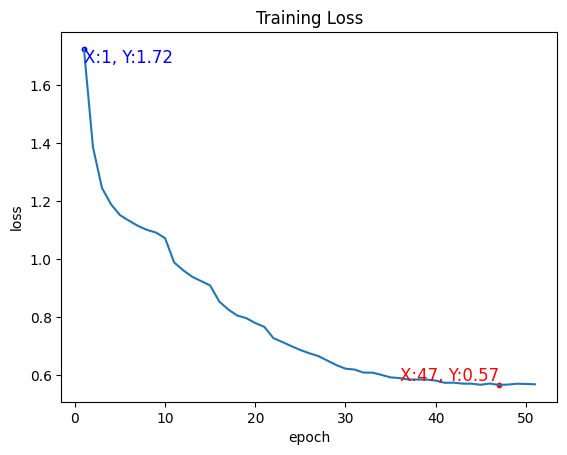

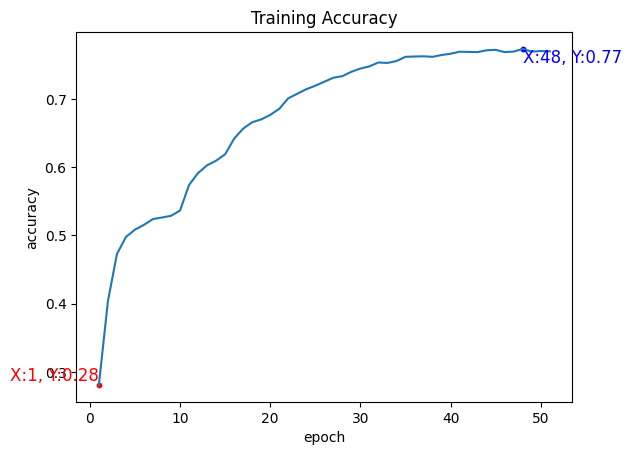

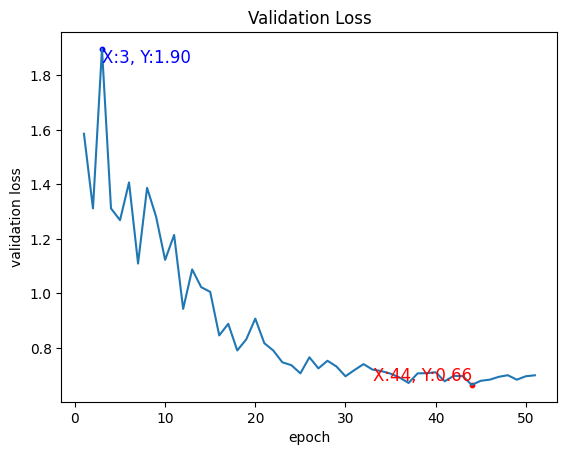

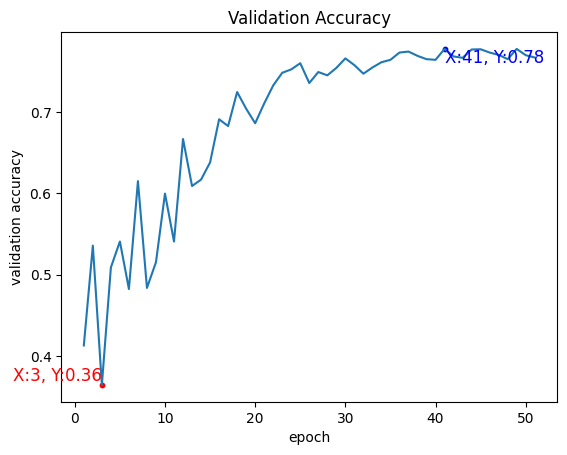

In [16]:
# draw graphs
data = utility.read_pickle_files(m.record_save_path + '/loss_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="loss", title="Training Loss", 
                    save_path=m.record_save_path+"/loss_history.png")

data = utility.read_pickle_files(m.record_save_path + '/accuracy_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="accuracy", title="Training Accuracy",
                    save_path=m.record_save_path+"/accuracy_history.png")

data = utility.read_pickle_files(m.record_save_path + '/val_loss_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation loss",
                    title="Validation Loss", save_path=m.record_save_path+"/val_loss_history.png")

data = utility.read_pickle_files(
    m.record_save_path + '/val_accuracy_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation accuracy",
                    title="Validation Accuracy", save_path=m.record_save_path+"/val_accuracy_history.png")


### Test Accuracy

model weight path: ./model_data/custom/v7.2_Adam_[RAF(AutoAug12x2),FER(AutoAug12x2)]_LRWB(M)_[L2:0.01]_2nd/model.pth
Test Accuracy: 78.71577574967405%
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       162
           1       0.38      0.57      0.46       160
           2       0.36      0.61      0.45        74
           3       0.95      0.85      0.90      1185
           4       0.72      0.85      0.78       680
           5       0.84      0.69      0.76       478
           6       0.87      0.75      0.80       329

    accuracy                           0.79      3068
   macro avg       0.69      0.72      0.69      3068
weighted avg       0.82      0.79      0.80      3068

model weight path: ./model_data/custom/v7.2_Adam_[RAF(AutoAug12x2),FER(AutoAug12x2)]_LRWB(M)_[L2:0.01]_2nd/manual_save_model.pth
Test Accuracy: 78.42242503259452%
              precision    recall  f1-score   support

           0       0.75      0.68 

0.7972620599739244

<Figure size 700x700 with 0 Axes>

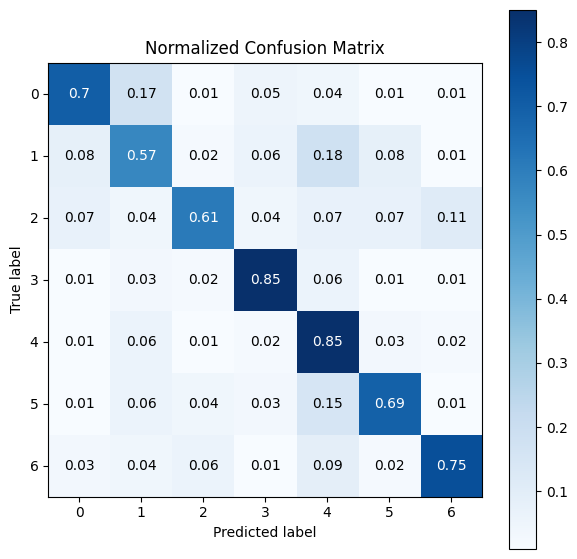

<Figure size 700x700 with 0 Axes>

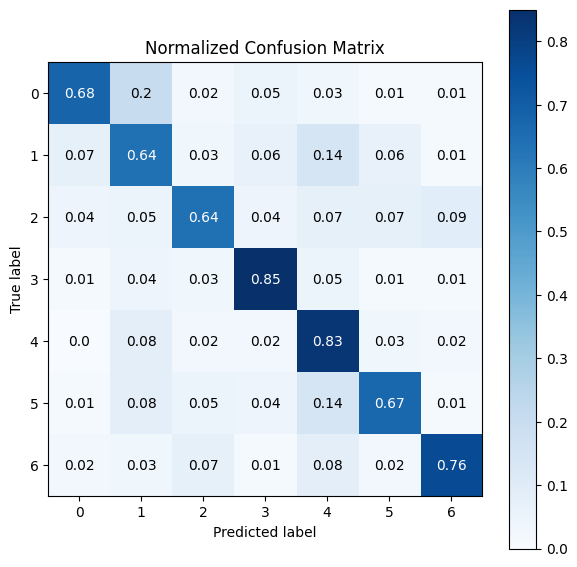

<Figure size 700x700 with 0 Axes>

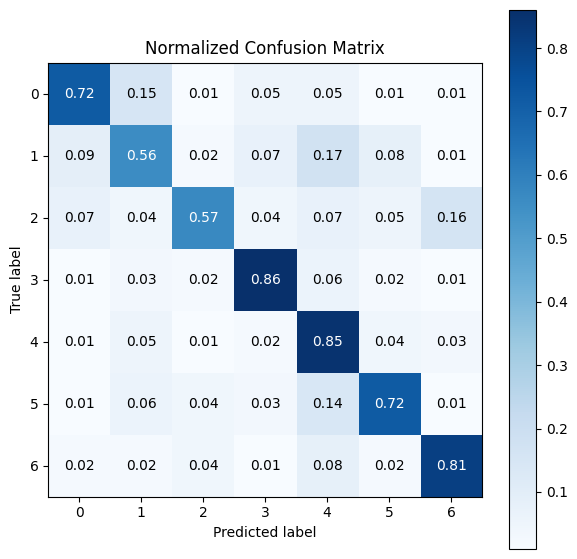

In [17]:
# evaluate model
print(f'model weight path: {m.pth_save_path}')
utility.model_validation(model, device, test_l1, m.pth_save_path, m.record_save_path, file_name='1')
print(f'model weight path: {m.pth_manual_save_path}')
utility.model_validation(model, device, test_l2, m.pth_manual_save_path, m.record_save_path, file_name='2')
print(f'model weight path: {m.pth_save_path_loss}')
utility.model_validation(model, device, test_l3, m.pth_save_path_loss, m.record_save_path, file_name='3')